In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = ResourceWarning)
warnings.filterwarnings('ignore', category = BytesWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0

In [2]:
import logging
logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)

In [3]:
from dask.distributed import Client
client = Client()
client

distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/32734469.gadi-pbs/dask-worker-space/worker-hzwxayiy', purging
distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/32734469.gadi-pbs/dask-worker-space/worker-lr2hrxp2', purging
distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/32734469.gadi-pbs/dask-worker-space/worker-31us7qba', purging
distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/32734469.gadi-pbs/dask-worker-space/worker-oceje97m', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39703,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://10.6.121.19:44417,Total threads: 4
Dashboard: /proxy/37379/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:45539,


In [4]:
db = '/scratch/x77/db6174/access-om2/archive/databases/1deg_jra55_ryf/cc_database_param_KPP_extended.db'
session_cont = cc.database.create_session(db)

db = '/scratch/x77/db6174/mom/archive/databases/1deg_jra55_ryf/cc_database_flux_forced_attempt3.db'
session_mffa = cc.database.create_session(db)

expt = ['1deg_jra55_ryf_param_KPP_extended', '1deg_jra55_ryf_flux_forced_attempt3']
session = [session_cont, session_mffa]
name = ['Control', 'Mean flux forcing']

In [5]:
start_time = '2000-01-01'
end_time = '2099-12-31'

start_time_last = '2095-01-01'
end_time_last = end_time

In [6]:
ncoarse = 12

x_min = [-100, -250, -70, -250]
x_max = [ 10 , -100,  20, -80 ]
y_min = [ 20 ,  20 , -80, -80 ]
y_max = [ 75 ,  75 , -55, -55 ]
basin = ['NA', 'NP', 'SA', 'SP']

In [7]:
## Pre-processing data: Changing time to be of same type

# For monthly fields
real_time_monthly = cc.querying.getvar(expt = expt[0], session = session[0], variable = 'hblt', frequency = '1 monthly').time

# For daily fields
real_time_daily = cc.querying.getvar(expt = expt[0], session = session[0], variable = 'temp_global_ave', frequency = '1 daily').time

## Surface temperature

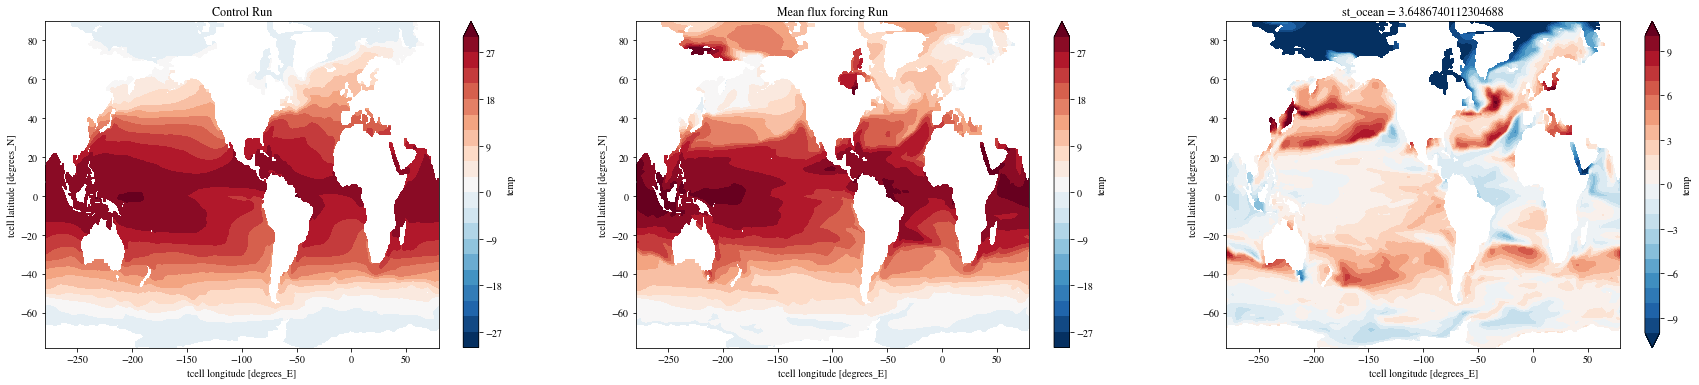

In [8]:
fig, axes = plt.subplots(ncols = 3, figsize = (30, 6))

for i, j in enumerate(session):
    
    temp_sfc = cc.querying.getvar(expt = expt[i], session = j, variable = 'temp', frequency = '1 monthly')
    temp_sfc["time"] = real_time_monthly
    temp_sfc = temp_sfc.sel(time = slice(start_time_last, end_time_last))
    temp_sfc = temp_sfc.isel(st_ocean = 1) - 273.15
    if(i == 0):
        tmpy = temp_sfc
    else:
        (tmpy - temp_sfc).mean('time').plot.contourf(ax = axes[2], levels = np.linspace(-10, 10, 21))
    temp_sfc.mean('time').plot.contourf(ax = axes[int(i%2)], levels = np.linspace(-30, 30, 21))
    axes[i].set_title(name[i] + ' Run')

## Surface salinity

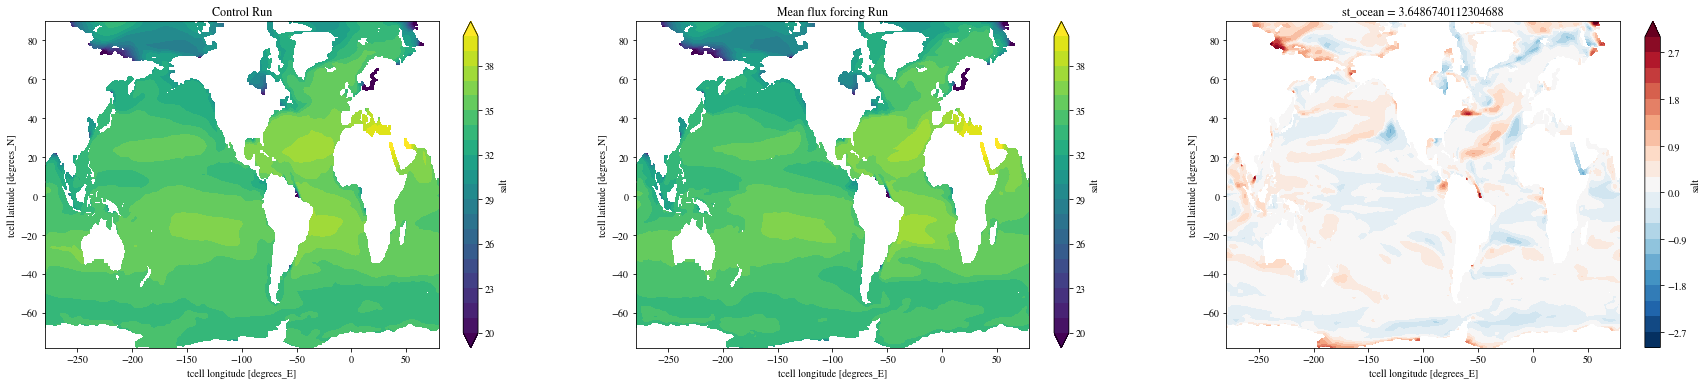

In [9]:
fig, axes = plt.subplots(ncols = 3, figsize = (30, 6))

for i, j in enumerate(session):
    
    salt_sfc = cc.querying.getvar(expt = expt[i], session = j, variable = 'salt', frequency = '1 monthly')
    salt_sfc["time"] = real_time_monthly
    salt_sfc = salt_sfc.sel(time = slice(start_time_last, end_time_last))
    salt_sfc = salt_sfc.isel(st_ocean = 1)
    if(i == 0):
        tmpy = salt_sfc
    else:
        (tmpy - salt_sfc).mean('time').plot.contourf(ax = axes[2], levels = np.linspace(-3, 3, 21))
    salt_sfc.mean('time').plot.contourf(ax = axes[int(i%2)], levels = np.linspace(20, 40, 21))
    axes[i].set_title(name[i] + ' Run')

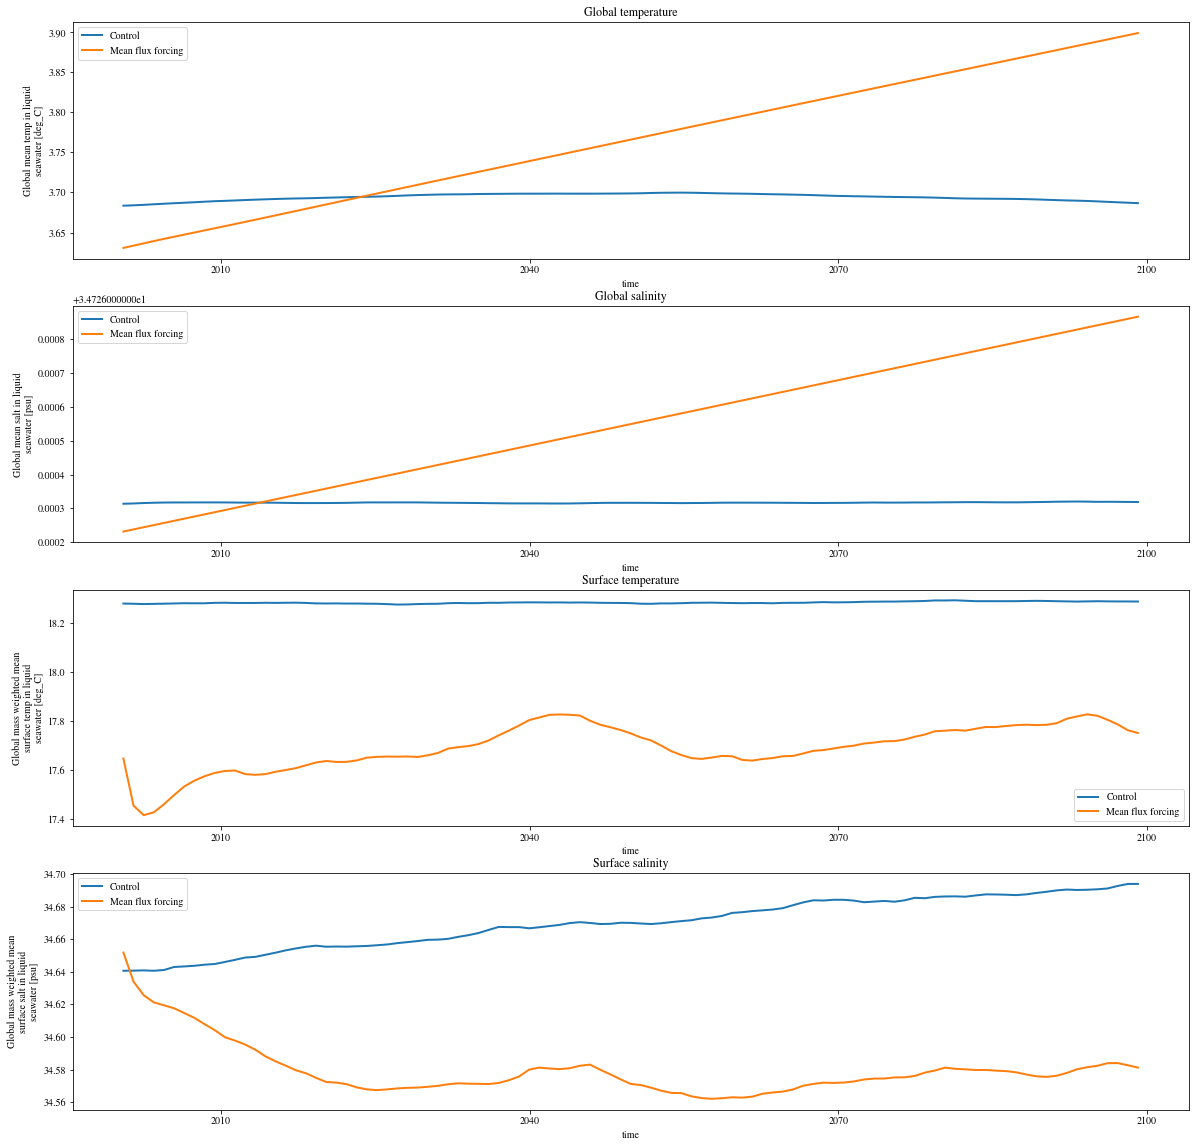

In [10]:
ncoarse = 12

fig, axes = plt.subplots(nrows = 4, figsize = (20, 20))

var_list = ['temp_global_ave',    'salt_global_ave', 'temp_surface_ave',    'salt_surface_ave']
var_name = ['Global temperature', 'Global salinity', 'Surface temperature', 'Surface salinity']
for i, j in enumerate(expt):
    for k, l in enumerate(var_list):
        variable = cc.querying.getvar(expt = expt[i], session = session[i], variable = l)
        variable["time"] = real_time_daily
        variable = variable.sel(time = slice('1900-01-01', end_time))
        variable = variable.coarsen({"time": ncoarse*30}, boundary = "trim").mean()
        variable.plot(ax = axes[k], label = name[i])
        axes[k].legend()
        axes[k].set_title(var_name[k])

## Surface heat flux

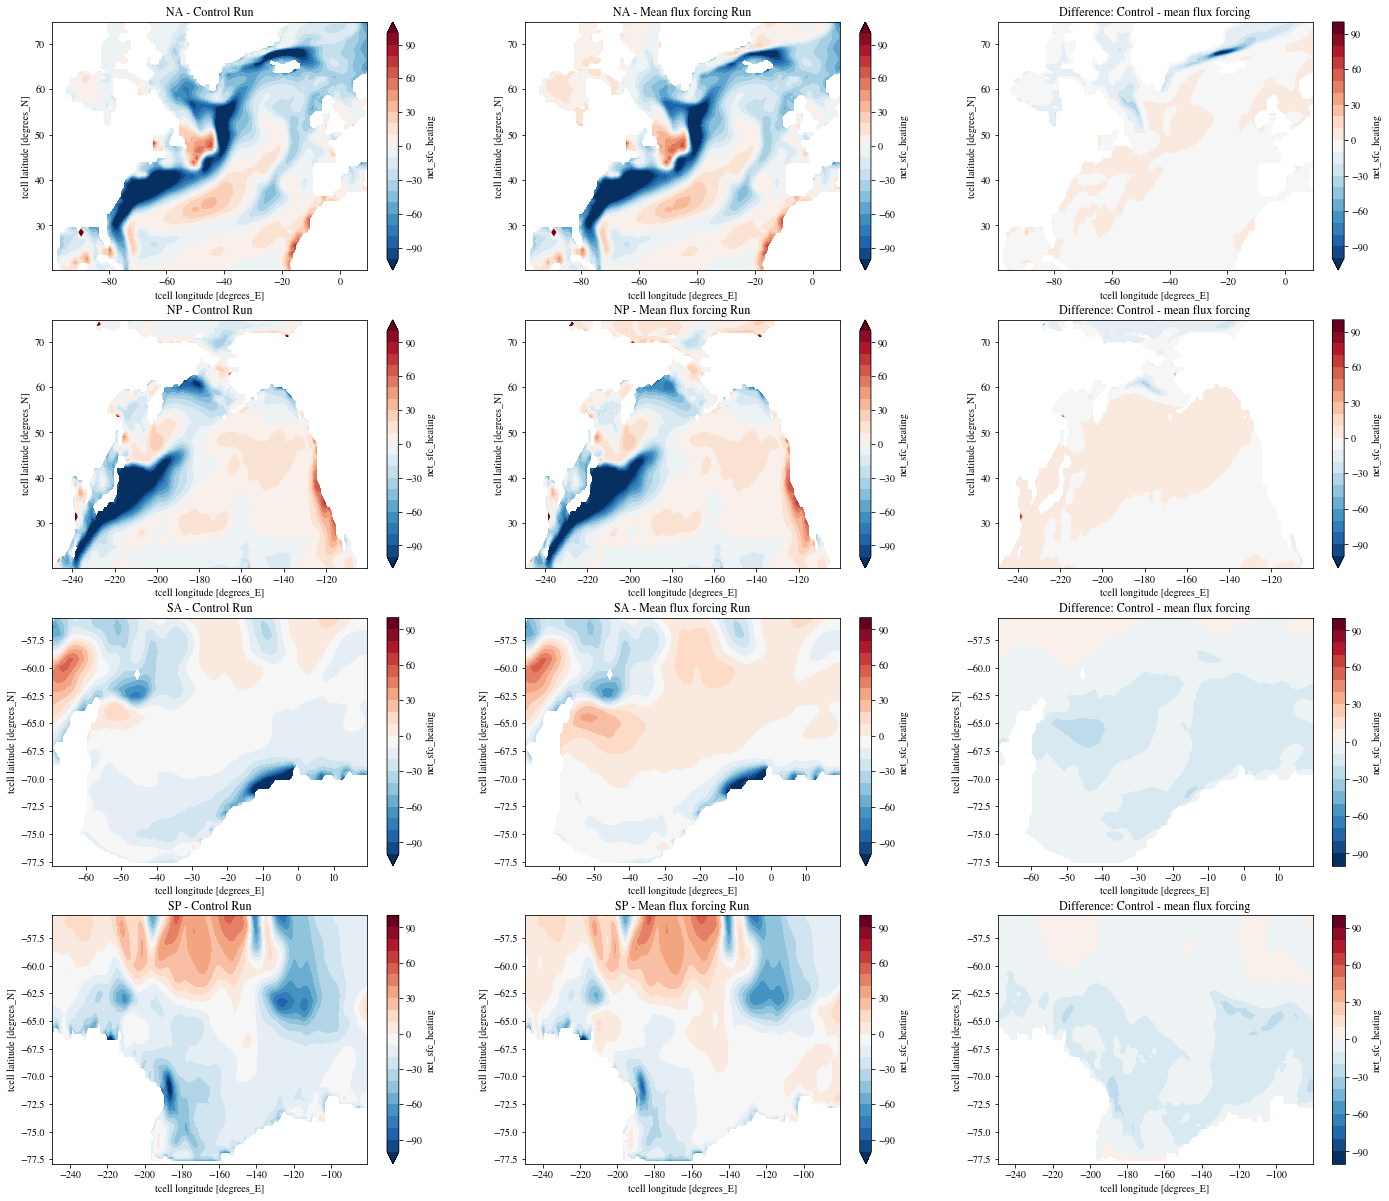

In [11]:
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (24, 21))

diff = 0
for i, j in enumerate(session):
    sfc_heat = cc.querying.getvar(expt = expt[i], session = j, variable = 'net_sfc_heating', frequency = '1 monthly')
    
    sfc_heat["time"] = real_time_monthly
    sfc_heat = sfc_heat.sel(time = slice('2000-01-01', '2004-12-31'))
    
    if(i == 0):
        diff = sfc_heat
    else:
        diff = diff - sfc_heat
        
    for k, l in enumerate(basin):
        sfc_heat_basin = sfc_heat.sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
        sfc_heat_basin.mean('time').plot.contourf(ax = axes[k][i], levels = np.linspace(-100, 100, 21))
        axes[k][i].set_title(str(basin[k]) + ' - ' + name[i] + ' Run')
        
        if(i == 1):
            diff.sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k])).mean(
                'time').plot.contourf(ax = axes[k][2], levels = np.linspace(-100, 100, 21))
            axes[k][2].set_title('Difference: Control - mean flux forcing')
            #axes[k][2].gridlines(color='grey', linestyle='--')

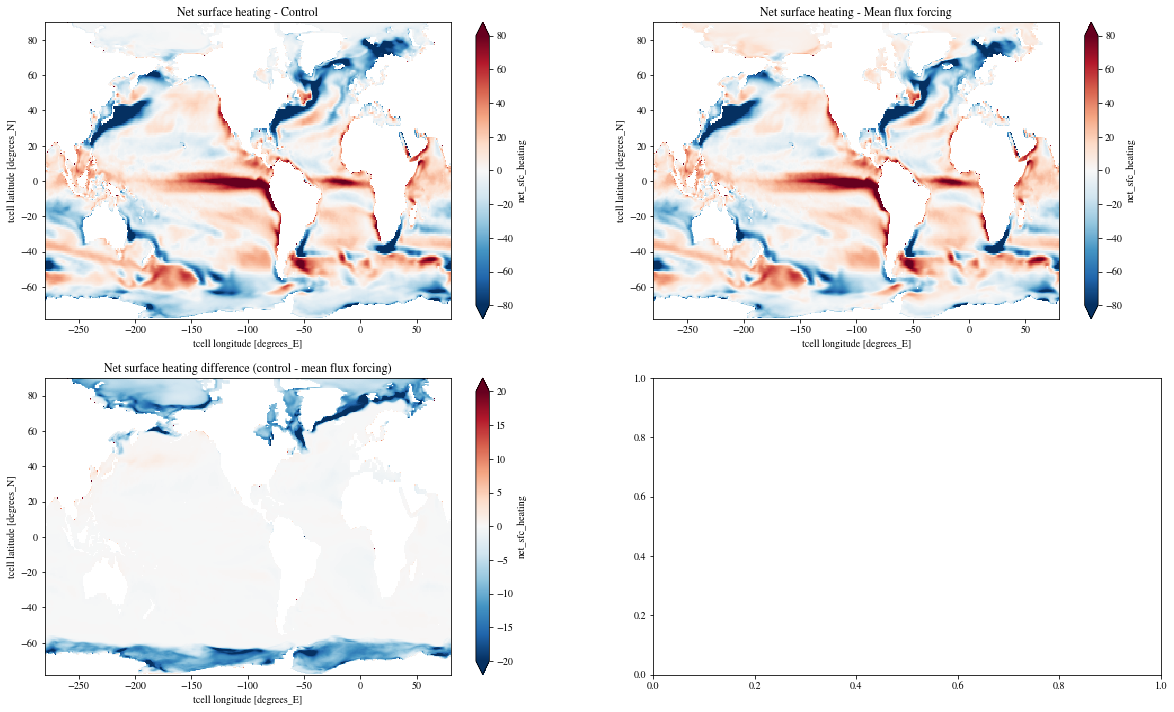

In [12]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 12))
for i, j in enumerate(session):
    
    heat = cc.querying.getvar(expt = expt[i], session = j, variable = 'net_sfc_heating', frequency = '1 monthly')
    heat["time"] = real_time_monthly
    #heat = heat.sel(time = slice(start_time_last, end_time_last))
    heat = heat.sel(time = slice('2000-01-01', '2004-12-31'))
    
    heat.mean('time').plot(ax = axes[int(i/2)][int(i%2)], vmin = -80, vmax = 80, cmap = 'RdBu_r')
    axes[int(i/2)][int(i%2)].set_title('Net surface heating - ' + name[i])

for i, j in enumerate([session_mffa]):

    heat_cont = cc.querying.getvar(expt = expt[0], session = session[0], variable = 'net_sfc_heating', frequency = '1 monthly')
    heat_cont["time"] = real_time_monthly
    heat_cont = heat_cont.sel(time = slice('2000-01-01', '2004-12-31'))

    heat_wfsh = cc.querying.getvar(expt = expt[i+1], session = j, variable = 'net_sfc_heating', frequency = '1 monthly')
    heat_wfsh["time"] = real_time_monthly
    heat_wfsh = heat_wfsh.sel(time = slice('2000-01-01', '2004-12-31'))
    (heat_cont - heat_wfsh).mean('time').plot(ax = axes[1][i], vmin = -20, vmax = 20, cmap = 'RdBu_r')

    axes[1][0].set_title('Net surface heating difference (control - mean flux forcing)')

## What makes up the net_sfc_heating?

The total heat flux into the ocean from surface forcing and ice-ocean exchanges is:

net_sfc_heating + frazil_3d_int_z

where,

net_sfc_heating = sfc_hflux_coupler + sfc_hflux_pme + sfc_hflux_from_runoff + sfc_hflux_from_calving

sfc_hflux_coupler = swflx + lw_heat + fprec_melt_heat + calving_melt_heat + sens_heat + evap_heat + mh_flux + liceht

Note the calving terms and liceht are currently zero in ACCESS-OM.

We don't have the following flux terms included:
1. frazil_3d_int_z
2. sfc_hflux_pme
3. sfc_hflux_from_runoff
4. sfc_hflux_from_calving
5. fprec_melt_heat
6. calving_melt_heat
7. mh_flux
8. liceht

Below are plots for all these fluxes.

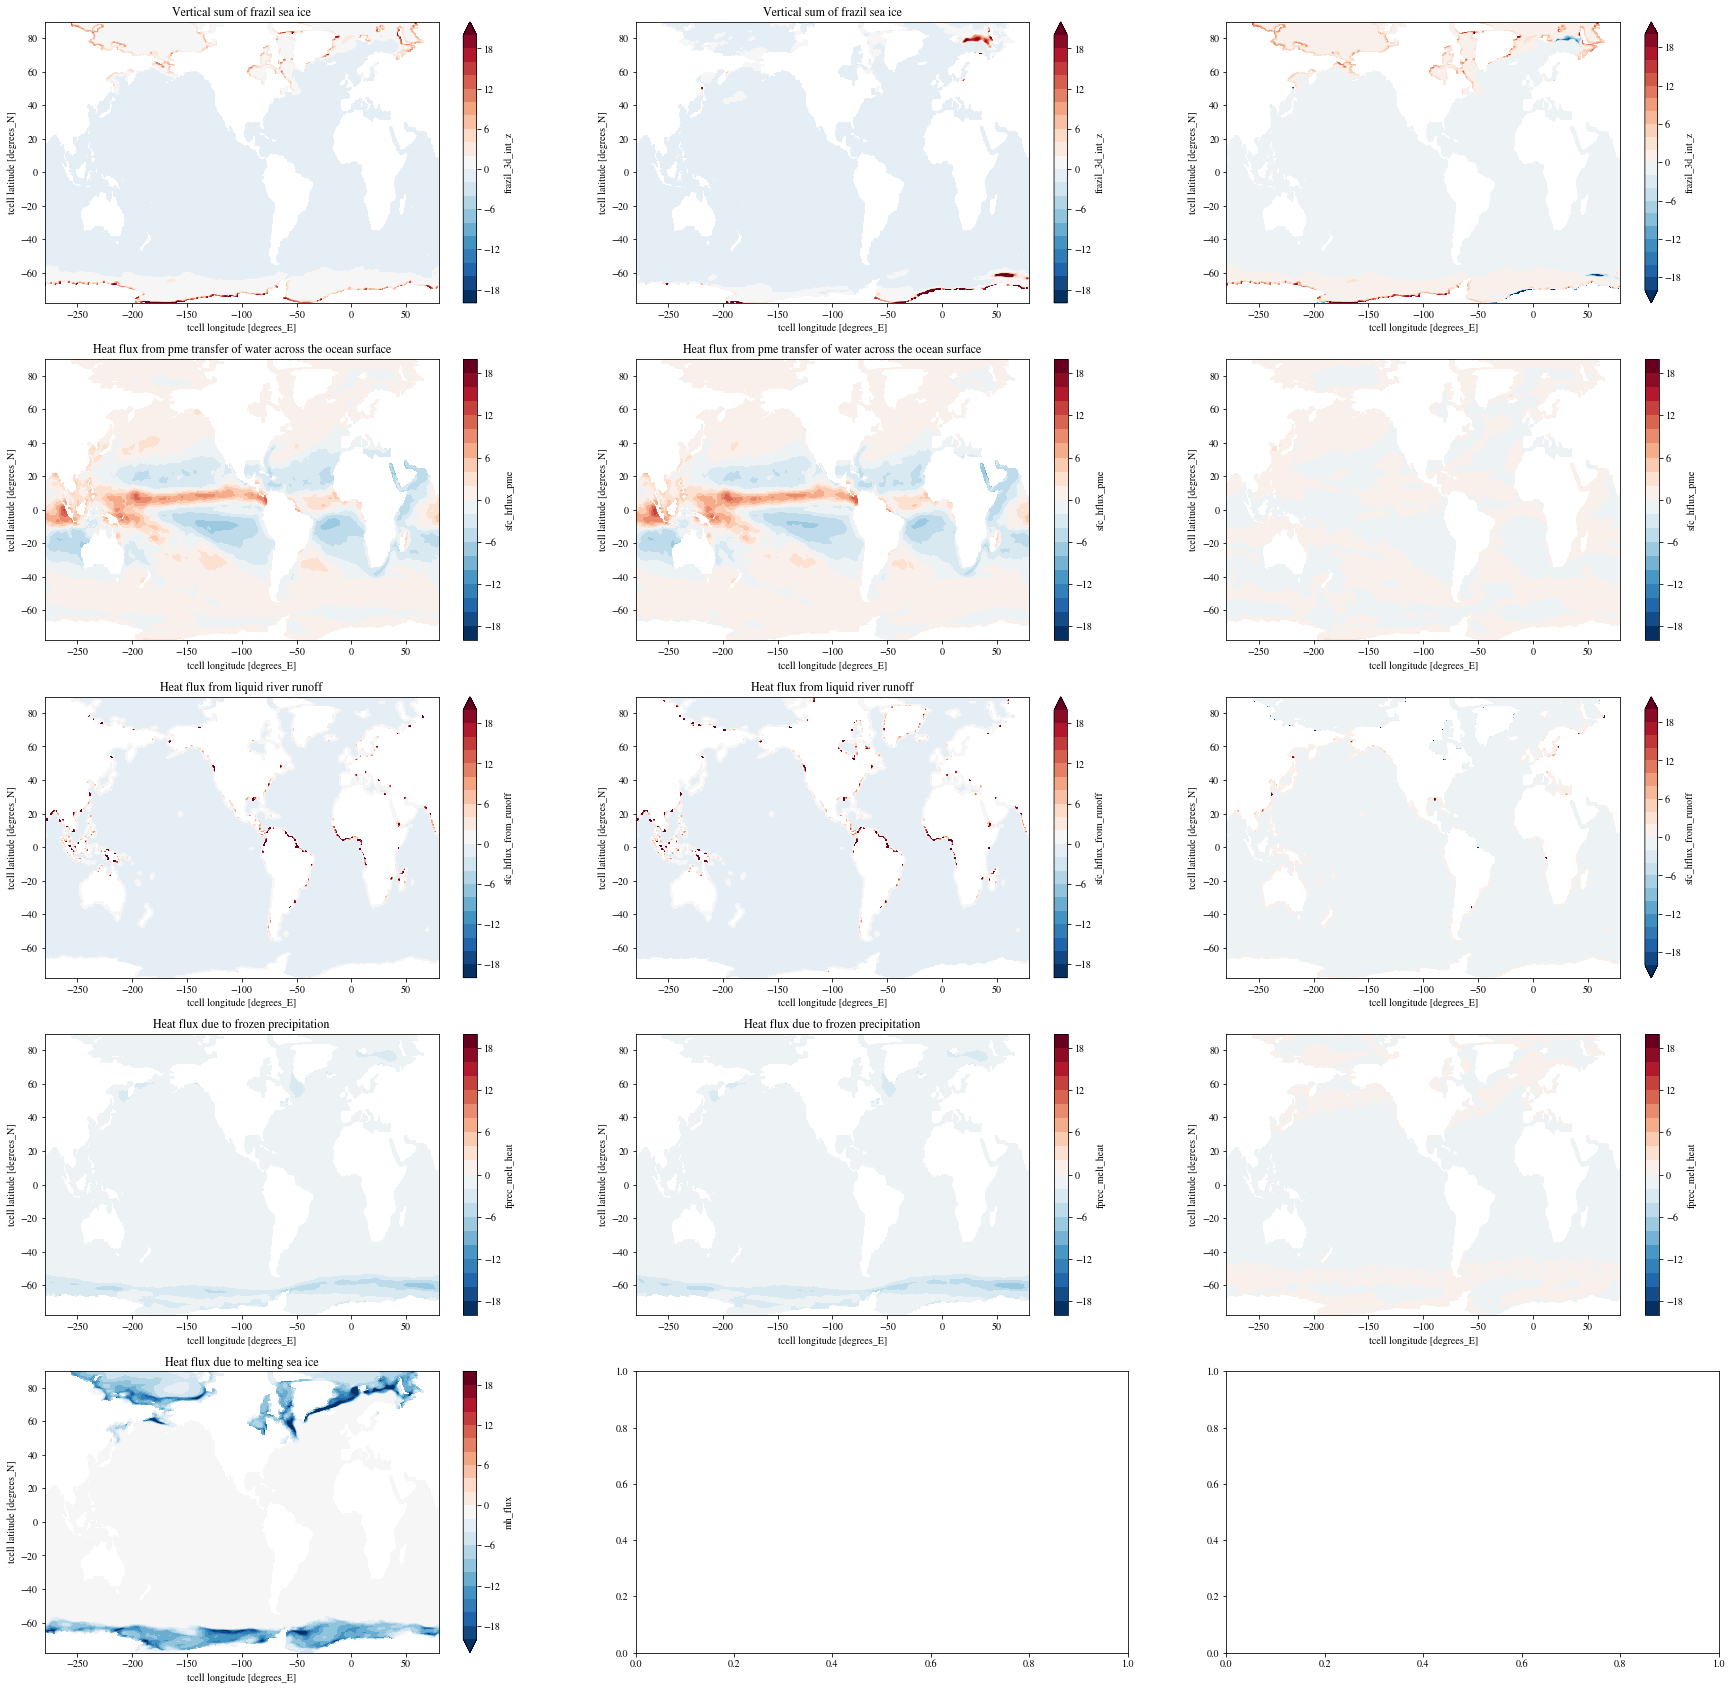

In [13]:
fig, axes = plt.subplots(nrows = 5, ncols = 3, figsize = (30, 30))

# 'sfc_hflux_from_calving', 'calving_melt_heat' and  'liceht' are not present. But I think it they are zero anyways.

var_list = ['frazil_3d_int_z', 'sfc_hflux_pme', 'sfc_hflux_from_runoff', 'fprec_melt_heat', 'mh_flux']
var_name = ['Vertical sum of frazil sea ice', 'Heat flux from pme transfer of water across the ocean surface', 'Heat flux from liquid river runoff', 'Heat flux due to frozen precipitation', 'Heat flux due to melting sea ice']

for k, l in enumerate(var_list):
    for i, j in enumerate(session):
        if(k!=4 or i!=1):
            variable = cc.querying.getvar(expt = expt[i], session = j, variable = l, frequency = '1 monthly')
            variable["time"] = real_time_monthly 
            variable.sel(time = slice('2000-01-01', '2004-12-31'))
            variable.mean('time').plot.contourf(ax = axes[k][i], levels = np.linspace(-20, 20, 21))
            axes[k][i].set_title(var_name[k])
        
        if(k!=4 and i == 0):
            diff = variable
        elif(k!=4 and i == 1):
            diff = diff - variable
            diff.mean('time').plot.contourf(ax = axes[k][2], levels = np.linspace(-20, 20, 21))

## Maps of volume fluxes

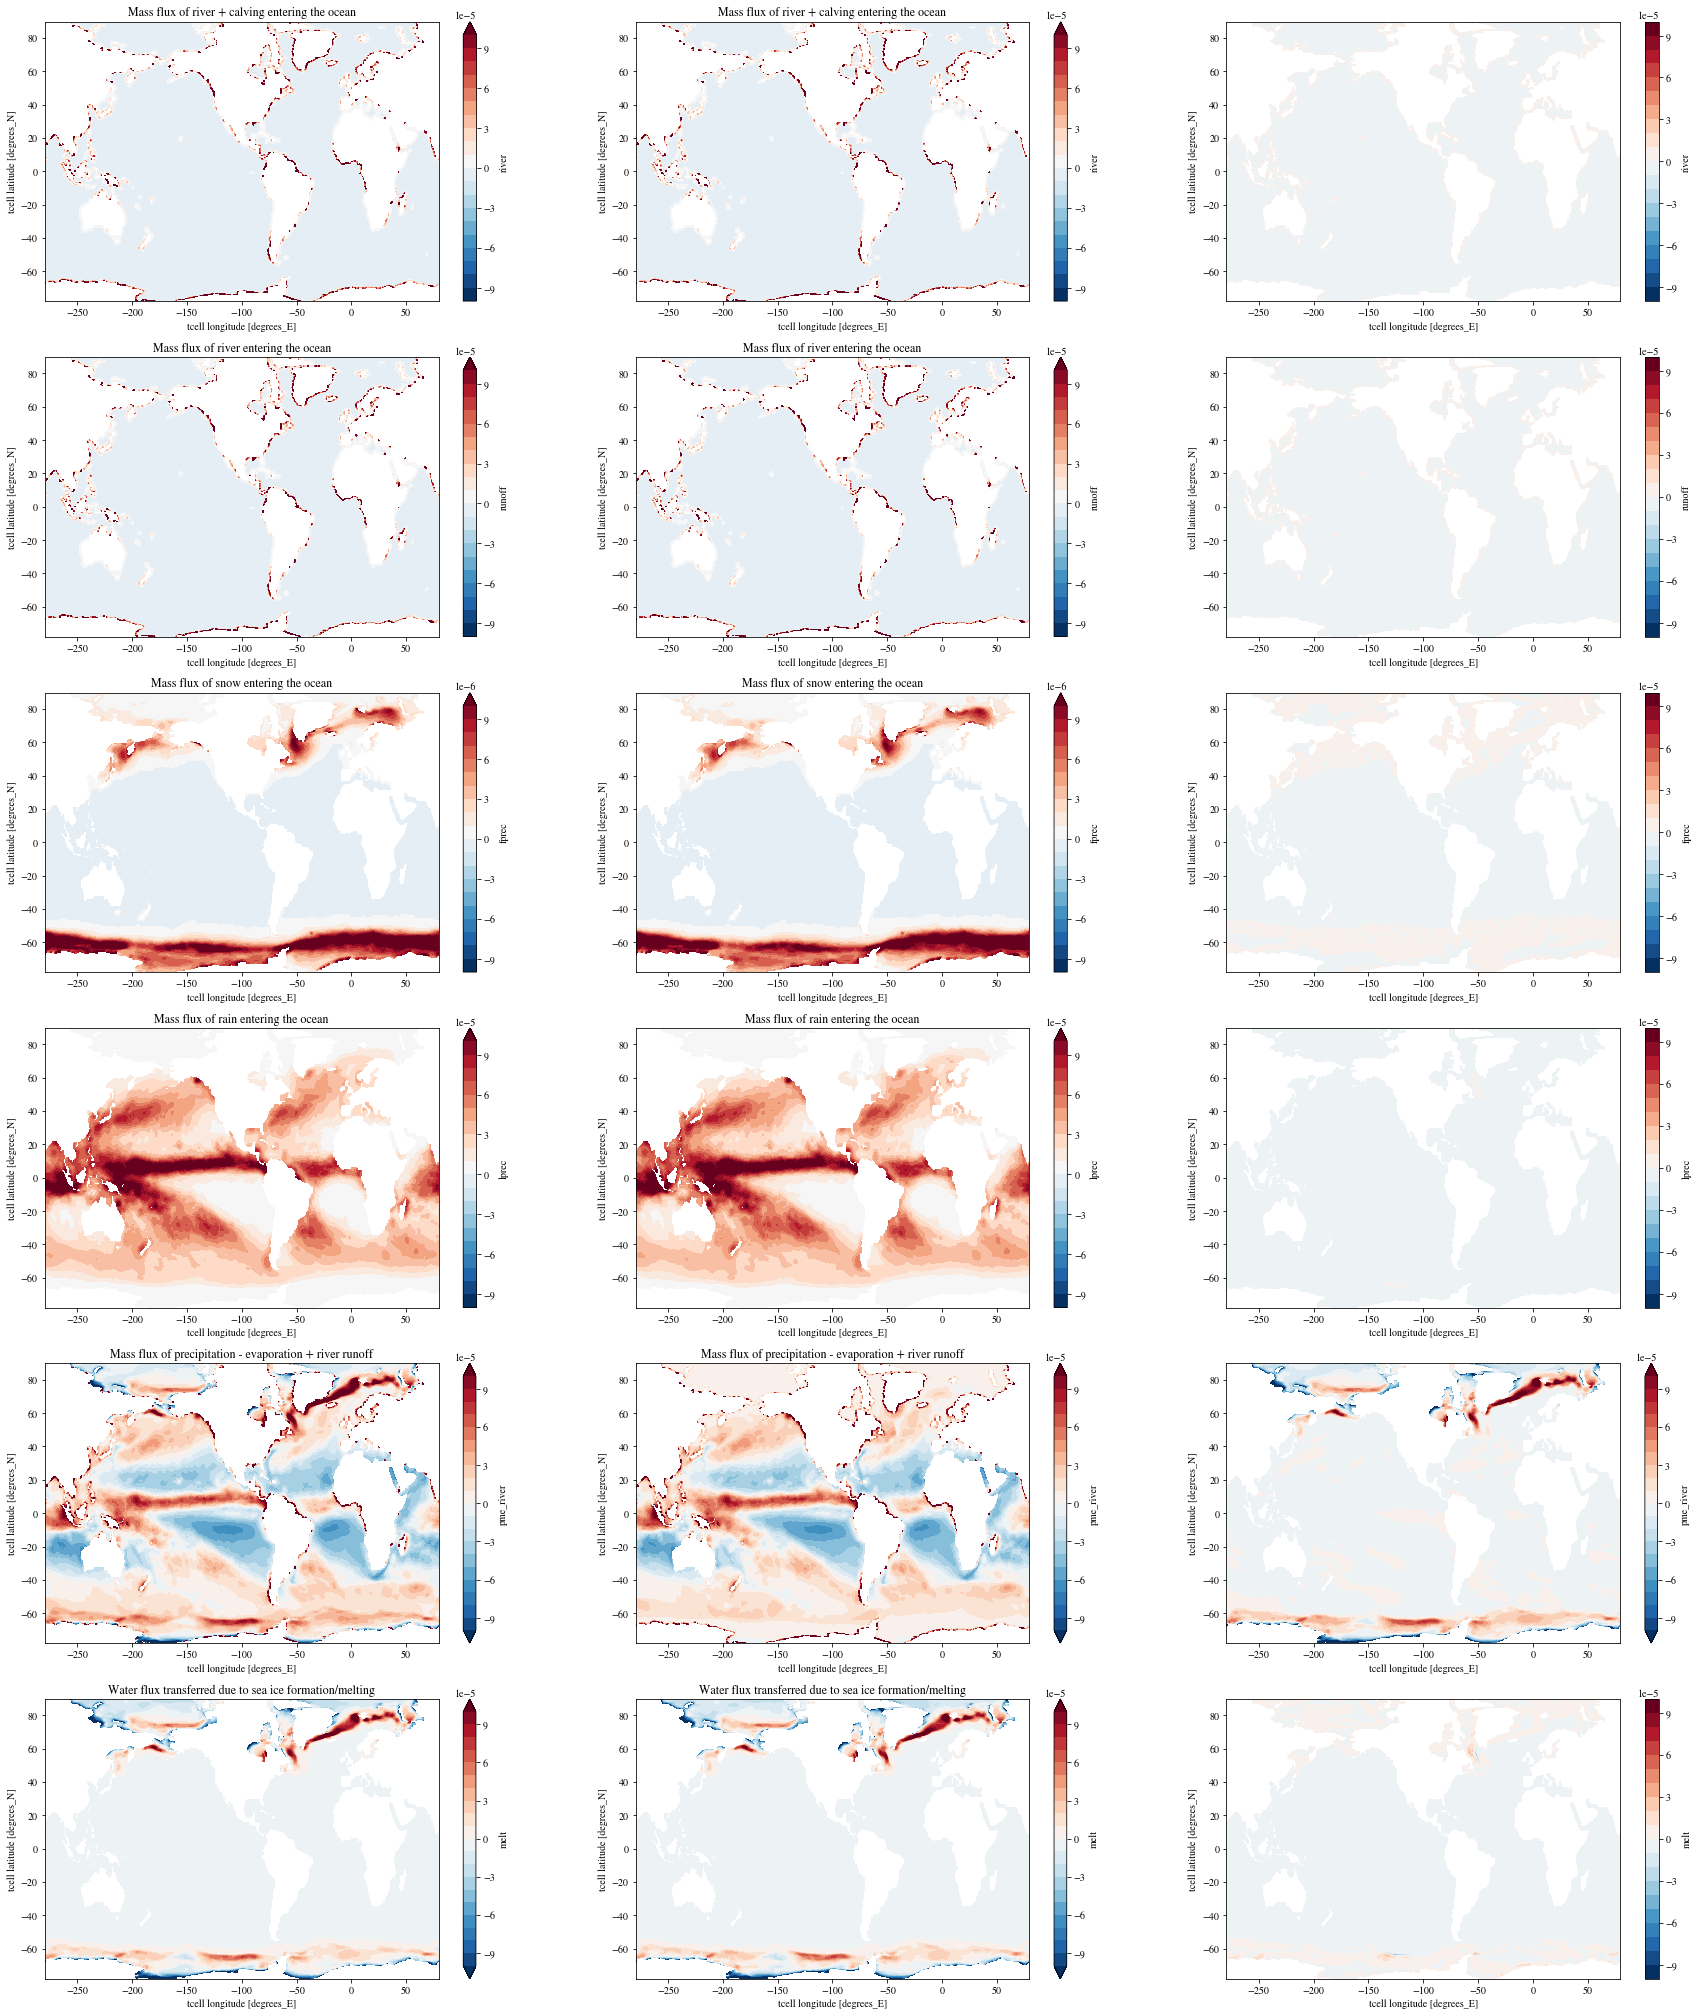

In [14]:
fig, axes = plt.subplots(nrows = 6, ncols = 3, figsize = (30, 36))

# 'sfc_hflux_from_calving', 'calving_melt_heat' and  'liceht' are not present. But I think it they are zero anyways.

var_list = ['river',    'runoff', 'fprec',    'lprec', 'pme_river', 'melt']
var_name = ['Mass flux of river + calving entering the ocean', 
            'Mass flux of river entering the ocean', 
            'Mass flux of snow entering the ocean', 
            'Mass flux of rain entering the ocean',
            'Mass flux of precipitation - evaporation + river runoff',
            'Water flux transferred due to sea ice formation/melting']

for k, l in enumerate(var_list):
    for i, j in enumerate(session):

        variable = cc.querying.getvar(expt = expt[i], session = j, variable = l, frequency = '1 monthly')
        variable["time"] = real_time_monthly 
        variable.sel(time = slice('2000-01-01', '2004-12-31'))
        if(k!=2):
            variable.mean('time').plot.contourf(ax = axes[k][i], levels = np.linspace(-1e-4, 1e-4, 21))
        else:
            variable.mean('time').plot.contourf(ax = axes[k][i], levels = np.linspace(-1e-5, 1e-5, 21))
        axes[k][i].set_title(var_name[k])
        
        if(i == 0):
            diff = variable
        elif(i == 1):
            diff = diff - variable
            diff.mean('time').plot.contourf(ax = axes[k][2], levels = np.linspace(-1e-4, 1e-4, 21))

## Scalar diagnostics of volume fluxes

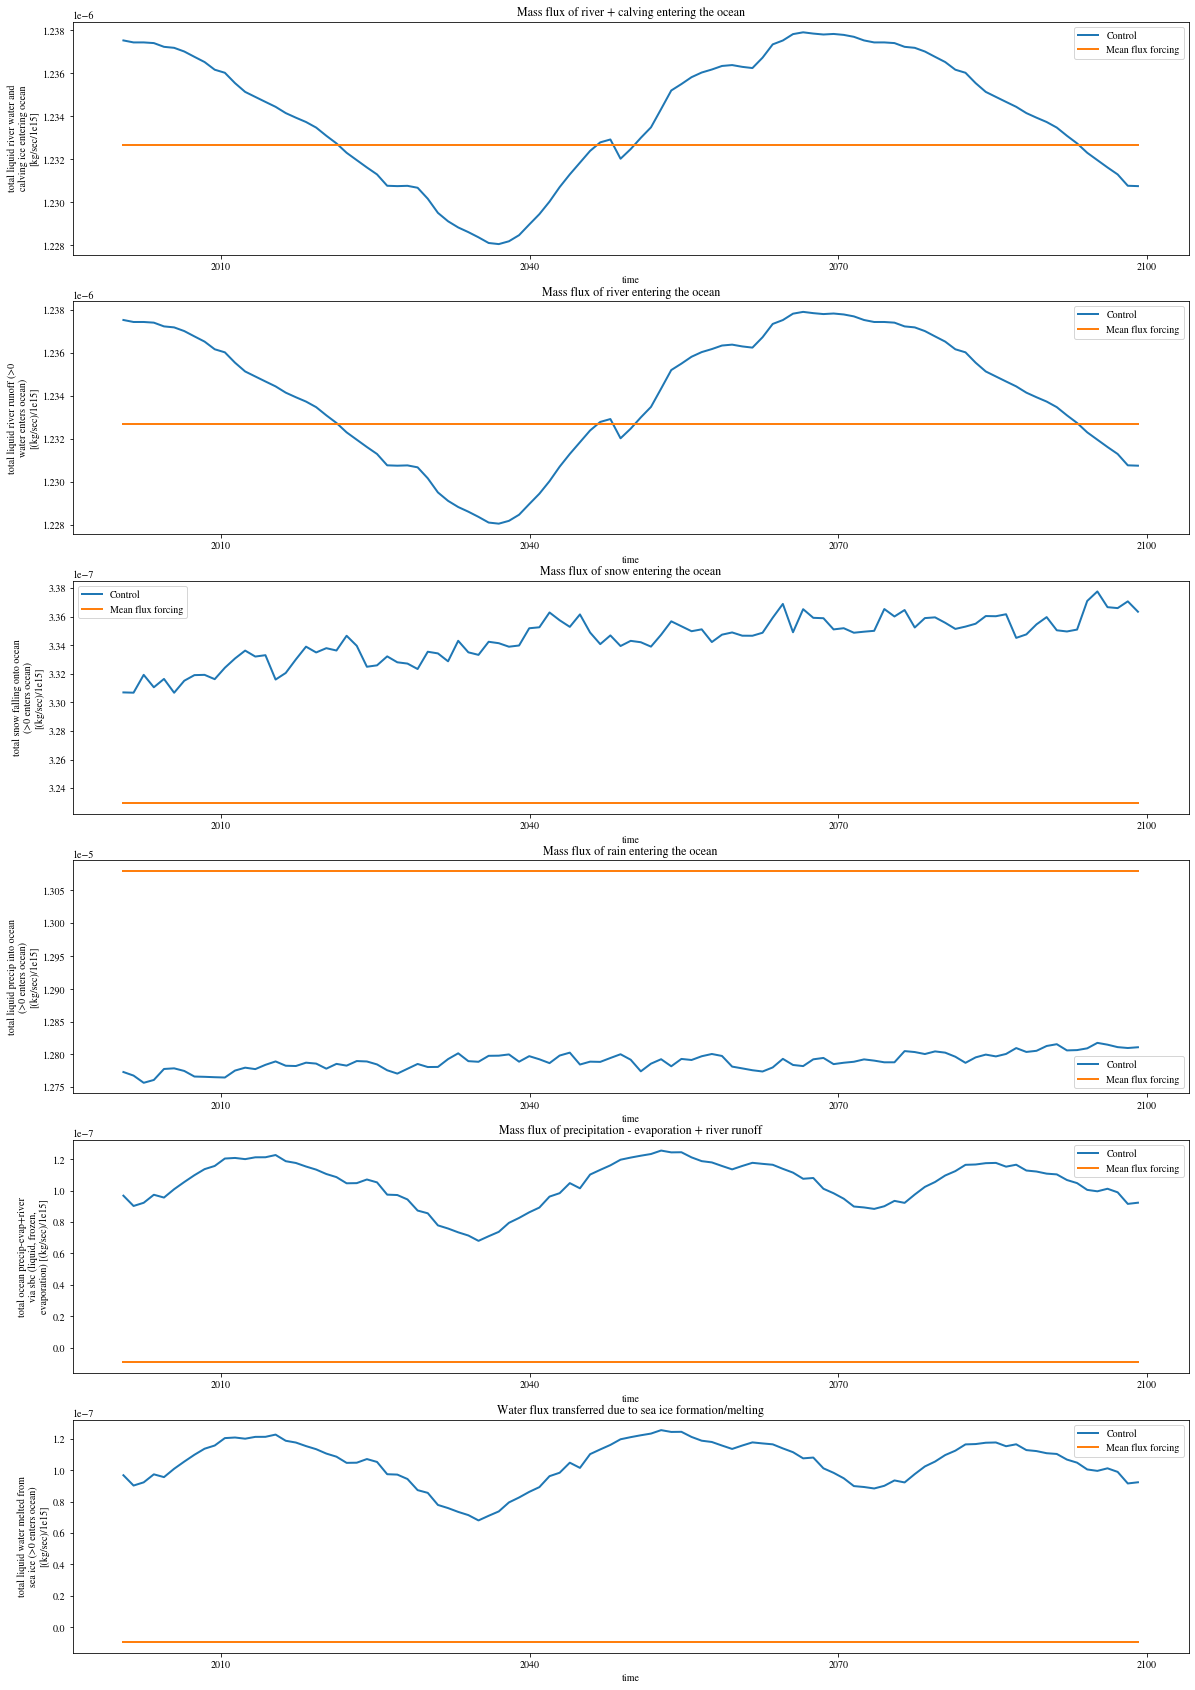

In [15]:
ncoarse = 12

fig, axes = plt.subplots(nrows = 6, figsize = (20, 30))

var_list = ['total_ocean_river', 'total_ocean_runoff', 'total_ocean_fprec', 'total_ocean_lprec', 'total_ocean_pme_river', 'total_ocean_melt']
var_name = ['Mass flux of river + calving entering the ocean', 
            'Mass flux of river entering the ocean', 
            'Mass flux of snow entering the ocean', 
            'Mass flux of rain entering the ocean',
            'Mass flux of precipitation - evaporation + river runoff',
            'Water flux transferred due to sea ice formation/melting']

for i, j in enumerate(session):
    for k, l in enumerate(var_list):
        variable = cc.querying.getvar(expt = expt[i], session = j, variable = l)
        variable["time"] = real_time_daily
        variable = variable.sel(time = slice('2000-01-01', end_time))
        variable = variable.coarsen({"time": ncoarse*30}, boundary = "trim").mean()
        variable.plot(ax = axes[k], label = name[i])
        axes[k].legend()
        axes[k].set_title(var_name[k])

## Energetics

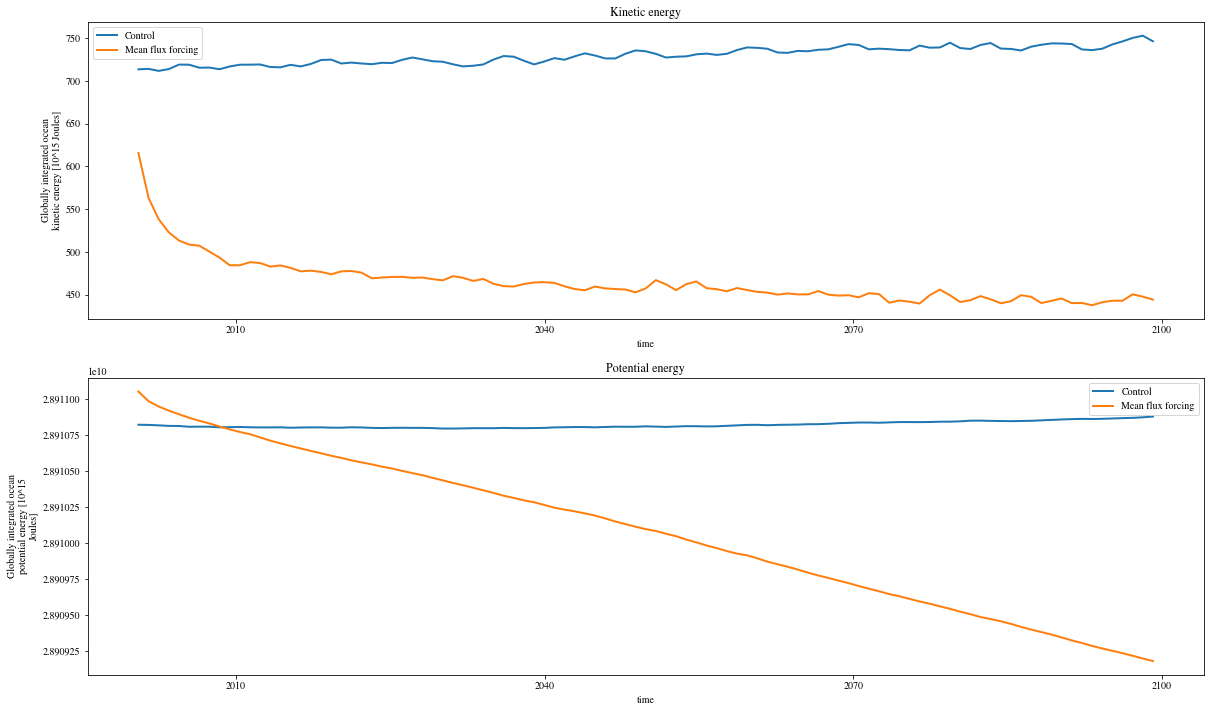

In [16]:
fig, axes = plt.subplots(nrows = 2, figsize = (20, 12))

var_list = ['ke_tot',         'pe_tot'          ]
var_name = ['Kinetic energy', 'Potential energy']
for i, j in enumerate(expt):
    for k, l in enumerate(var_list):
        variable = cc.querying.getvar(expt = expt[i], session = session[i], variable = l)
        variable["time"] = real_time_daily
        variable = variable.sel(time = slice('1900-01-01', end_time))
        variable = variable.coarsen({"time": ncoarse*30}, boundary = "trim").mean()
        variable.plot(ax = axes[k], label = name[i])
        axes[k].legend()
        axes[k].set_title(var_name[k])

## Gyres

In [17]:
rho0 = 1025
start_time_gyre = '2090-01-01'
end_time_gyre = end_time

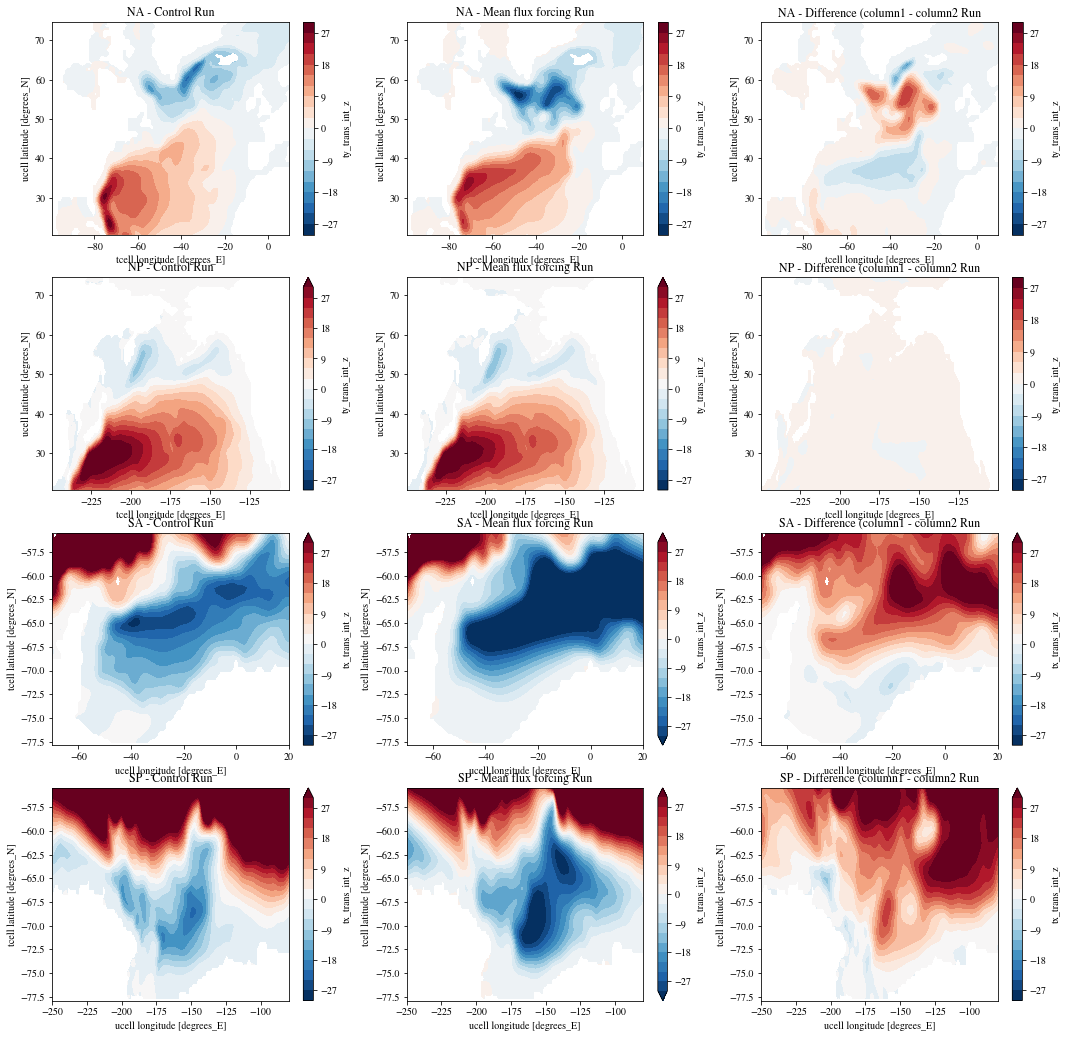

In [18]:
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (18, 18))

for i, j in enumerate(session):
    tx_trans = cc.querying.getvar(expt = expt[i], session = j, variable = 'tx_trans_int_z', frequency = '1 monthly')
    tx_trans["time"] = real_time_monthly
    tx_trans = tx_trans.sel(time = slice(start_time_gyre, end_time_gyre))
    ty_trans = cc.querying.getvar(expt = expt[i], session = j, variable = 'ty_trans_int_z', frequency = '1 monthly')
    ty_trans["time"] = real_time_monthly
    ty_trans = ty_trans.sel(time = slice(start_time_gyre, end_time_gyre))
    
    if(i == 0):
        diffx = tx_trans
        diffy = ty_trans
    else:
        diffx = diffx - tx_trans
        diffy = diffy - ty_trans
    
    for k, l in enumerate(basin):
        if(l == 'NA' or l == 'NP'):
            ty_basin = ty_trans.sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yu_ocean = slice(y_min[k], y_max[k]))
            psi_basin = ty_basin.cumsum('xt_ocean').where(abs(ty_basin<=1.e20))/(rho0*1.e6)
        else:
            tx_basin = tx_trans.sel(xu_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
            psi_basin = tx_basin.cumsum('yt_ocean').where(abs(tx_basin<=1.e20))/(rho0*1.e6)
            
        psi_basin.sel(time = slice(start_time, end_time)).mean('time').plot.contourf(ax = axes[k][i], levels = np.linspace(-30, 30, 21))
        axes[k][i].set_title(str(basin[k]) + ' - ' + name[i] + ' Run')
        
        if(i == 1):
            if(l == 'NA' or l == 'NP'):
                diff_basin = diffy.sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yu_ocean = slice(y_min[k], y_max[k]))
                psi_basin = diff_basin.cumsum('xt_ocean').where(abs(ty_basin<=1.e20))/(rho0*1.e6)
            else:
                diff_basin = diffx.sel(xu_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
                psi_basin = diff_basin.cumsum('yt_ocean').where(abs(tx_basin<=1.e20))/(rho0*1.e6)
            
            psi_basin.sel(time = slice(start_time, end_time)).mean('time').plot.contourf(ax = axes[k][2], levels = np.linspace(-30, 30, 21))
            axes[k][2].set_title(str(basin[k]) + ' - Difference (column1 - column2 Run')

## Overturning circulation

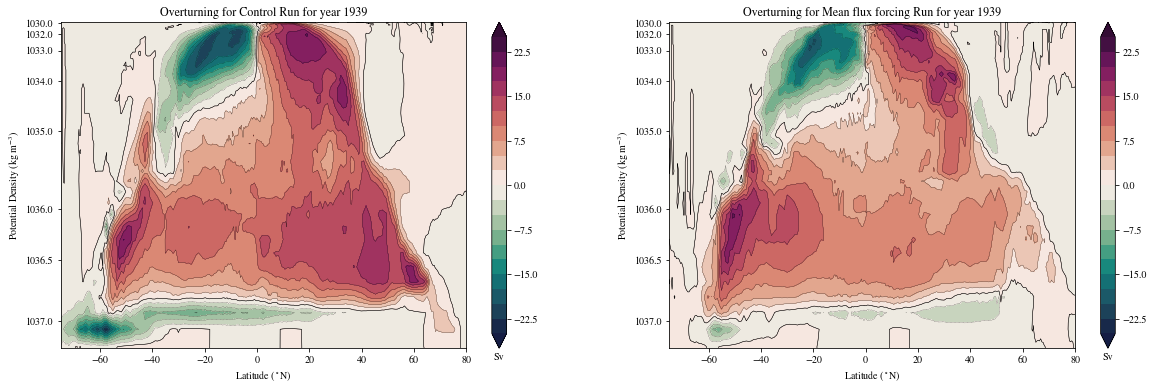

In [19]:
fig, ax = plt.subplots(ncols = 2, figsize = (20, 6)) 
#clev = np.arange(-25, 27, 2)
clev = np.linspace(-25, 25, 21)
yticks = np.array([1030, 1032, 1033, 1034, 1035, 1036,1036.5, 1037])
scfac = 4  ## A power to set teh stretching
start_time_OC = '2099-01-01'
end_time_OC = '2099-12-31'
rho = 1025 # mean density of sea-water in kg/m^3

for i, j in enumerate(session):
    
    psiGM = cc.querying.getvar(expt[i], 'ty_trans_rho_gm', session = j)
    psiGM["time"] = real_time_monthly
    psiGM = psiGM.sel(time = slice(start_time_OC, end_time_OC))
    psiGM = psiGM.sum('grid_xt_ocean')
    psiGM = psiGM / (1e6*rho)
    
    psi = cc.querying.getvar(expt[i], 'ty_trans_rho', session = j)
    psi["time"] = real_time_monthly
    psi = psi.sel(time = slice(start_time_OC, end_time_OC))
    psi = psi.sum('grid_xt_ocean').sel(time = slice(start_time_OC, end_time_OC))
    psi = psi / (1e6*rho) # converts kg/s to Sv
    psi_avg = psi.cumsum('potrho').mean('time') #- psi.sum('potrho').mean('time')
    
    psi_avg = psi_avg + psiGM.mean('time')

    p1 = ax[int(i%2)].contourf(psi_avg.grid_yu_ocean,(psi_avg.potrho-1028)**scfac, psi_avg, cmap=cm.cm.curl, levels = clev, extend = 'both')
    cb = plt.colorbar(p1, orientation = 'vertical', ax = ax[int(i%2)])
    cb.ax.set_xlabel('Sv')
    ax[int(i%2)].contour(psi_avg.grid_yu_ocean,(psi_avg.potrho - 1028)**scfac, psi_avg, levels = clev, colors = 'k', linewidths = 0.25)
    ax[int(i%2)].contour(psi_avg.grid_yu_ocean,(psi_avg.potrho - 1028)**scfac, psi_avg, levels = [0.0,], colors = 'k', linewidths = 0.5)

    ax[int(i%2)].set_yticks((yticks-1028)**scfac)
    ax[int(i%2)].set_yticklabels(yticks)
    ax[int(i%2)].set_ylim([0.5**scfac, 9.2**scfac])
    ax[int(i%2)].invert_yaxis()
    ax[int(i%2)].set_ylabel('Potential Density (kg m$^{-3}$)')
    ax[int(i%2)].set_xlabel('Latitude ($^\circ$N)')
    ax[int(i%2)].set_xlim([-75,80])
    ax[int(i%2)].set_title('Overturning for ' + str(name[i]) + ' Run for year 1939');

### Sector overturning

In [20]:
def compute_basin_psi_rho(expt,session, basin_mask, nbound=None, start_time = start_time_OC, end_time = end_time_OC):
    rho = 1025 # mean density of sea-water in kg/m^3
    
    varlist = cc.querying.get_variables(session, expt)
    if varlist['name'].str.contains('ty_trans_rho_gm').any():
        GM = True
        print('GM is True')
        psiGM = cc.querying.getvar(expt,'ty_trans_rho_gm',session, n=nbound)
        psiGM["time"] = real_time_monthly
        psiGM = psiGM.sel(time = slice(start_time_OC, end_time_OC))
        psiGM = psiGM.sum('grid_xt_ocean')
        psiGM = psiGM / (1e6*rho)
    else:
        GM = False
        print('GM is False')
        
    psi = cc.querying.getvar(expt, 'ty_trans_rho',session, n=nbound)
    psi["time"] = real_time_monthly
    psi = psi.sel(time = slice(start_time_OC, end_time_OC))
    psi = psi / (1e6*rho) # converts kg/s to Sv
    psi = (psi * basin_mask).sum('grid_xt_ocean').cumsum('potrho').mean(dim = 'time').load() 
    if GM:
        psi = psi + psiGM.mean('time')
        
    return psi

GM is True
GM is True
GM is True
GM is True


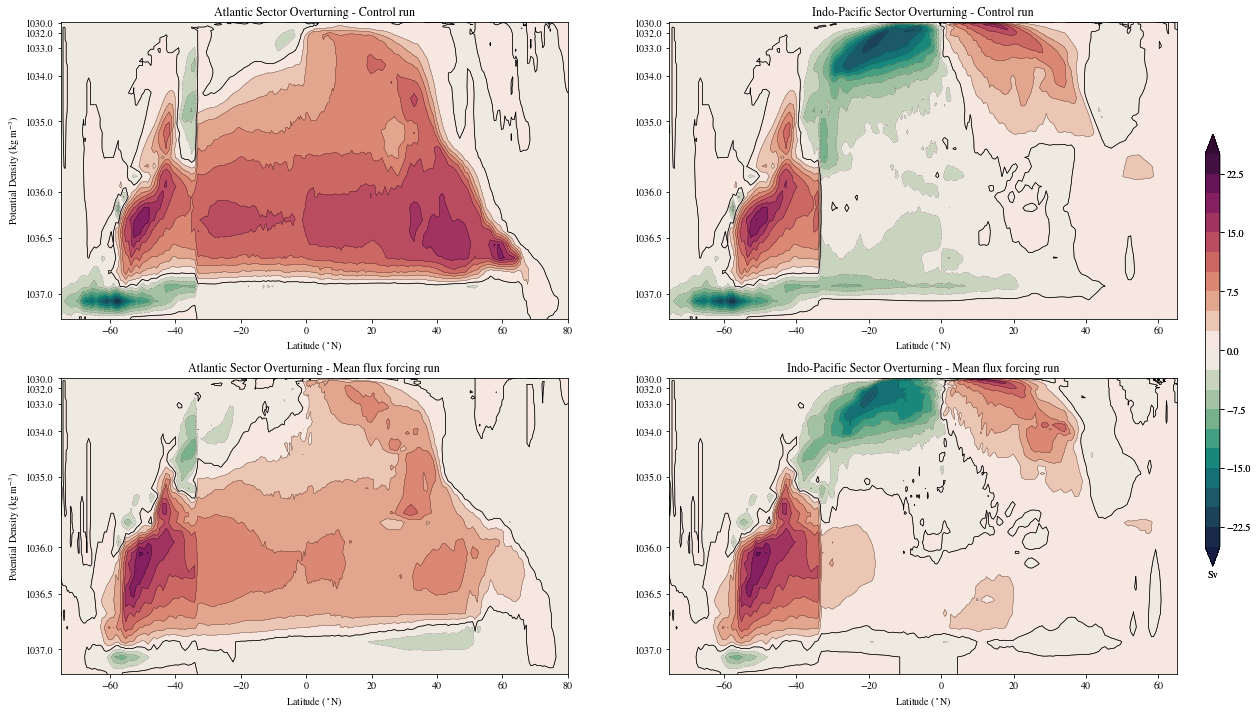

In [21]:
#clev=np.arange(-25,25,2)
clev = np.linspace(-25, 25, 21)
yticks = np.array([1030, 1032, 1033, 1034, 1035, 1036,1036.5, 1037])
scfac = 4  ## A power to set the stretching of the y-axis

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 12))

for i, j in enumerate(session):
    psi = cc.querying.getvar(expt[i], 'ty_trans_rho', session = j)
    psi["time"] = real_time_monthly
    psi = psi.sel(time = slice(start_time_OC, end_time_OC))
    ht = cc.querying.getvar(expt[i], 'ht', session = j, n = -1)
    land_mask = ~ht.isnull()

    south_map = (land_mask.where(land_mask.yt_ocean < -34)).fillna(0) 
    indo_map1 = (land_mask.where(land_mask.yt_ocean < 9).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-65)).fillna(0) 
    indo_map2 = (land_mask.where(land_mask.yt_ocean < 15).where(land_mask.yt_ocean > 9).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-83.7)).fillna(0) 
    indo_map3 = (land_mask.where(land_mask.yt_ocean < 17).where(land_mask.yt_ocean > 15).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-93.3)).fillna(0) 
    indo_map4 = (land_mask.where(land_mask.yt_ocean < 85).where(land_mask.yt_ocean > 17).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-99)).fillna(0) 
    indo_map5 = (land_mask.where(land_mask.yt_ocean < 30.5).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >25).where(land_mask.xt_ocean<80)).fillna(0) 
    
    indo_sector_map = indo_map1 + indo_map2 + indo_map3 + indo_map4 + indo_map5 + south_map
    indo_sector_mask = indo_sector_map.where(indo_sector_map>0)
    
    atlantic_sector_map = (indo_sector_mask * 0).fillna(1) * land_mask
    atlantic_sector_map = atlantic_sector_map + south_map
    atlantic_sector_mask = atlantic_sector_map.where(atlantic_sector_map>0)
    
    indo_sector_mask.coords['xt_ocean'] = psi.grid_xt_ocean.values
    indo_sector_mask.coords['yt_ocean'] = psi.grid_yu_ocean.values
    indo_sector_mask = indo_sector_mask.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yu_ocean'})
    
    atlantic_sector_mask.coords['xt_ocean'] = psi.grid_xt_ocean.values
    atlantic_sector_mask.coords['yt_ocean'] = psi.grid_yu_ocean.values
    atlantic_sector_mask = atlantic_sector_mask.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yu_ocean'})

    atlantic_psi = compute_basin_psi_rho(expt[i], j, atlantic_sector_mask, start_time = start_time_OC, end_time = end_time)
    indopacific_psi = compute_basin_psi_rho(expt[i], j, indo_sector_mask, start_time = start_time_OC, end_time = end_time)
    
    p1 = axes[i][0].contourf(atlantic_psi.grid_yu_ocean,(atlantic_psi.potrho-1028)**scfac, atlantic_psi, cmap=cm.cm.curl, levels=clev, extend='both')
    axes[i][0].contour(atlantic_psi.grid_yu_ocean,(atlantic_psi.potrho-1028)**scfac, atlantic_psi, levels=clev, colors='k', linewidths=0.25)
    axes[i][0].contour(atlantic_psi.grid_yu_ocean,(atlantic_psi.potrho-1028)**scfac, atlantic_psi, levels=[0.0,], colors='k', linewidths=0.75)
    axes[i][0].set_yticks((yticks-1028)**scfac)
    axes[i][0].set_yticklabels(yticks)
    axes[i][0].set_ylim([0.5**scfac, 9.2**scfac])
    axes[i][0].invert_yaxis()
    axes[i][0].set_ylabel('Potential Density (kg m$^{-3}$)')
    axes[i][0].set_xlabel('Latitude ($^\circ$N)')
    axes[i][0].set_xlim([-75,80])
    axes[i][0].set_title('Atlantic Sector Overturning - ' + name[i] + ' run');

    ## Plotting Indo-Pacific Sector
    p1 = axes[i][1].contourf(indopacific_psi.grid_yu_ocean,(indopacific_psi.potrho-1028)**scfac, indopacific_psi, cmap=cm.cm.curl, levels=clev, extend='both')
    axes[i][1].contour(indopacific_psi.grid_yu_ocean,(indopacific_psi.potrho-1028)**scfac, indopacific_psi, levels=clev, colors='k', linewidths=0.25)
    axes[i][1].contour(indopacific_psi.grid_yu_ocean,(indopacific_psi.potrho-1028)**scfac, indopacific_psi, levels=[0.0,], colors='k', linewidths=0.75)
    axes[i][1].set_yticks((yticks-1028)**scfac)
    axes[i][1].set_yticklabels(yticks)
    axes[i][1].set_ylim([0.5**scfac, 9.2**scfac])
    axes[i][1].invert_yaxis()
    axes[i][1].set_xlabel('Latitude ($^\circ$N)')
    axes[i][1].set_xlim([-75,65])
    axes[i][1].set_title('Indo-Pacific Sector Overturning - ' + name[i] + ' run');

    # Plot a colorbar
    cax = plt.axes([0.92, 0.25, 0.01, 0.5])
    cb = plt.colorbar(p1, cax = cax,orientation = 'vertical', ax = axes[i])
    cb.ax.set_xlabel('Sv')

## Circulation metrics

### ACC Transport

Text(0.5, 1.0, 'Drake Passage Transport')

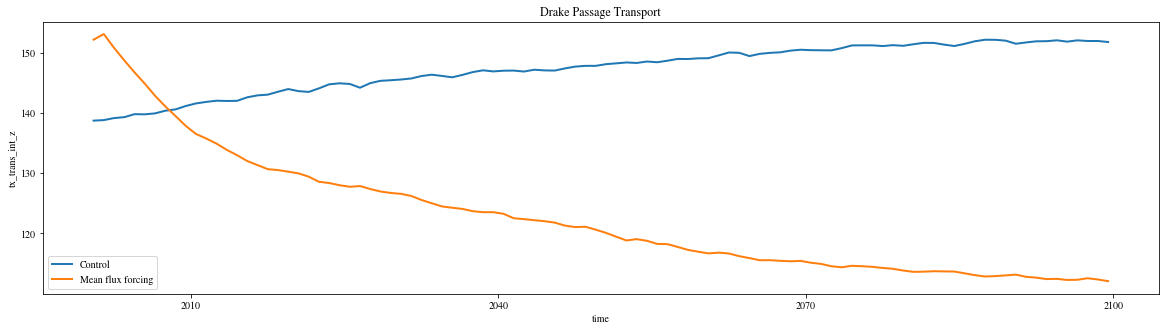

In [22]:
xmin = -69.9
ymin = -71.6
ymax = -51.0
rho0 = 1036

plt.figure(figsize = (20,5))

for i, j in enumerate(session):
    DP_trans = cc.querying.getvar(expt[i], 'tx_trans_int_z', session = j).sel(
        xu_ocean = xmin, method='nearest').sel(yt_ocean = slice(ymin, ymax)).sum('yt_ocean')/rho0/1e6
    DP_trans["time"] = real_time_monthly
    DP_trans = DP_trans.sel(time = slice('1900-01-01', end_time))
    DP_trans = DP_trans.coarsen({"time": ncoarse}, boundary = "trim").mean()
    DP_trans.plot(label = name[i])
    plt.legend()

plt.title('Drake Passage Transport')

### AABW Circulation

Text(0.5, 1.0, 'AABW Circulation')

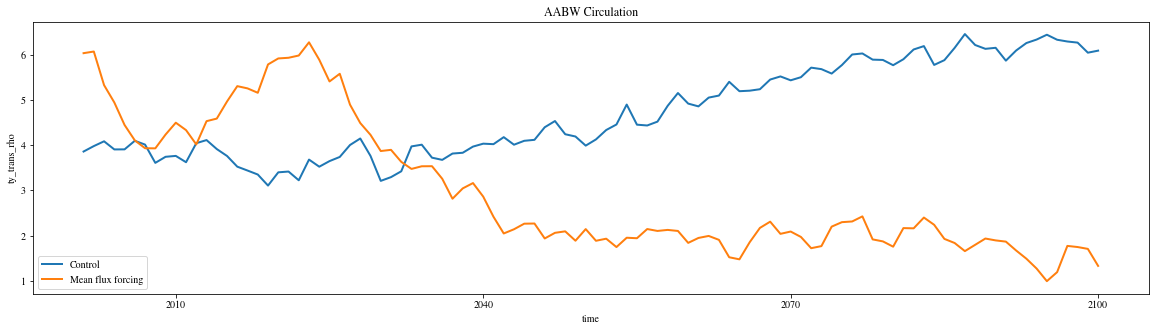

In [23]:
latitude = -45

plt.figure(figsize = (20,5))

for i, j in enumerate(session):
    psi_aabw = cc.querying.getvar(expt[i], 'ty_trans_rho', session = j).sum(
        'grid_xt_ocean').sel(method = 'nearest', grid_yu_ocean = latitude)*1.0e-9
    psi_aabw["time"] = real_time_monthly
    psi_aabw = psi_aabw.sel(time = slice('1900-01-01', end_time))
    psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')
    psi_aabw_sum = -psi_aabw_sum.sel(potrho = slice(1036.2, None)).min('potrho').resample(time = 'Y').mean()
    psi_aabw_sum.plot(label = name[i])
    plt.legend()

plt.title('AABW Circulation')

In [ ]:
plt.figure(figsize = (20,5))

for i, j in enumerate(session):
    psi_amoc = cc.querying.getvar(expt[i], 'ty_trans_rho', session = j).sel(
        grid_xt_ocean = slice(-103, -5)).sum('grid_xt_ocean').sel(method = 'Nearest', grid_yu_ocean = 26)*1.0e-9
    psi_amoc["time"] = real_time_monthly
    psi_amoc = psi_amoc.sel(time = slice('1900-01-01', end_time))
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    psi_amoc_sum = psi_amoc_sum.sel(potrho = slice(1035.5, None)).max('potrho').resample(time = 'Y').mean()
    psi_amoc_sum.plot(label = name[i])
    plt.legend()

plt.title('AMOC cell')

### Gulf stream transport

In [ ]:
xmin = -85
xmax = -75
ymin = 30
rho0 = 1030

plt.figure(figsize = (20,5))

for i, j in enumerate(session):
    GS = cc.querying.getvar(expt[i], 'ty_trans_int_z', session = j).sel(
        xt_ocean = slice(xmin, xmax)).sel(yu_ocean = ymin, method = 'nearest').sum('xt_ocean')/rho0/1e6
    GS["time"] = real_time_monthly
    GS = GS.sel(time = slice('1900-01-01', end_time))
    GS = GS.coarsen({"time": ncoarse}, boundary = "trim").mean()
    GS.plot(label = name[i])
    plt.legend()

plt.title('Gulf stream WBC')

### Kuroshio current

In [ ]:
xmin = -250
xmax = -210
ymin = 30
rho = 1030

plt.figure(figsize = (20,5))

for i, j in enumerate(session):
    KC = cc.querying.getvar(expt[i], 'ty_trans_int_z', session = j).sel(
        xt_ocean = slice(xmin, xmax)).sel(yu_ocean = ymin, method = 'nearest').sum('xt_ocean')/rho0/1e6
    KC["time"] = real_time_monthly
    KC = KC.sel(time = slice('1900-01-01', end_time))
    KC = KC.coarsen({"time": ncoarse}, boundary = "trim").mean()
    KC.plot(label = name[i])
    plt.legend()
    
plt.title('Kuroshio current WBC')